In [374]:
import torch
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, TensorDataset
from contextlib import contextmanager
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

cuda = torch.device("cuda")
cpu = torch.device("cpu")
dev = cuda if torch.cuda.is_available() else cpu

@contextmanager
def switch_to_cpu(model):
    global dev
    _dev = dev
    dev = cpu
    model.to(cpu)
    yield
    dev = _dev
    model.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def get_model():
    return nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
        nn.AvgPool2d(4),
        Lambda(lambda x: x.view(x.size(0), -1)),
    )


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def predict_batch(model, data_loader):
    reals = []
    preds = []
    for xb, yb in data_loader:
        reals.append(yb)
        preds.append(model(xb).argmax(dim=1))
        
    return (torch.cat(reals, 0), torch.cat(preds, 0))

def accuracy(model, data_loader):
    return accuracy_score(*predict_batch(model, data_loader))

def loss(model, loss_func, data_loader):
    losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in data_loader])
    return np.sum(np.multiply(losses, nums)) / np.sum(nums)



def fit(model, loss_func, opt, train_dl, *, valid_dl=None, max_epochs=20, threshold=1e-6, min_epochs=None, silent=False):
    validation = valid_dl is not None
    print("Fitting a model...")
    last_loss = float("inf")
    epoch = 1
    accuracies = []
    losses = []
    while True:
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        
        with torch.no_grad(), switch_to_cpu(model):
            # print diagnostics about current epoch
            if validation:
                val_loss = loss(model, loss_func, valid_dl)
                val_acc = accuracy(model, valid_dl)
            train_loss = loss(model, loss_func, train_dl)
            train_acc = accuracy(model, train_dl)
        if not silent:
            if validation:
                print("Epoch %s: val_loss=%s, train_loss=%s, val_acc=%s, train_acc=%s" % (epoch, val_loss, train_loss, val_acc, train_acc))
            else:
                print("Epoch %s: train_loss=%s, train_acc=%s" % (epoch, train_loss, train_acc))
        
        losses.append((val_loss, train_loss) if validation else train_loss)
        accuracies.append((val_acc, train_acc) if validation else train_acc)
        
        compare_loss = (val_loss if validation else train_loss)
        min_epochs_satisified = min_epochs is None or epoch >= min_epochs
        
        # stop execution
        if threshold and last_loss - compare_loss < threshold and min_epochs_satisified:
            print("delta loss %s was lower than threshold %s, stopping" % (last_loss - compare_loss, threshold))
            break
        
        if max_epochs is not None and epoch >= max_epochs and min_epochs_satisified:
            print("Max epochs reached, stopping")
            break
        last_loss = compare_loss
        epoch += 1
    return np.array([losses, accuracies])


def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

def get_dl(xs, ys, prep=preprocess, bs=30):
    return WrappedDataLoader(DataLoader(TensorDataset(xs.type(torch.float32), ys), batch_size=bs), prep)

def get_dls(xs, ys, prep=preprocess, bs=30):
    n = len(ys) // 5
    return {'valid': get_dl(xs[:n], ys[:n], prep, bs), 'train': get_dl(xs[n:], ys[n:], prep, bs)}
  

In [476]:
import numpy as np
import torch

import torchvision.transforms as tt
import torchvision.transforms.functional as tf
from random_erasing import RandomErasing
torch.manual_seed(213742069)
torch.cuda.manual_seed_all(213742069)
torch.cuda.manual_seed(213742069)
train = FashionMNIST('.', download=True, train=True)
model = get_model()
model.to(dev)

aff = tt.Compose([
    tt.RandomAffine(0, translate=(1 / 10, 1/10), shear=10, fillcolor=0),
    tt.ToTensor()
])
re = tt.Compose([
    Lambda(lambda z: z.view(1, 28, 28)),
    RandomErasing(1, sl=0.01, sh=0.05),
])

xs = train.train_data.type(torch.FloatTensor)
ys = train.train_labels
xs2 = []
ys2 = []
worse_ones = [3, 4, 5,7,  9]
boots = [5, 7, 9]

for x, y in zip(xs, ys):
    mod = re(x.clone())
    if torch.any(mod != x): 
        xs2.append(mod)
        ys2.append(y)
#     if y not in worse_ones:


xs = torch.cat([xs, torch.cat(xs2)])
ys = torch.cat([ys, torch.tensor(ys2)])
print("Augmented!")
xs, ys = next(iter(DataLoader(TensorDataset(xs, ys), shuffle=True, batch_size=100000000)))
dls = get_dls(xs, ys)
results = fit(model, F.cross_entropy, torch.optim.Adam(model.parameters()), dls['train'], valid_dl=dls['valid'], min_epochs=50, max_epochs=100)
print("DONE!")
# Epoch 51: val_loss=0.4049692894394199, train_loss=0.35769767411674064, val_acc=0.8584444444444445, train_acc=0.8688194444444445



Augmented!
Fitting a model...
Epoch 1: val_loss=0.5447108506970108, train_loss=0.5277742213569582, val_acc=0.803375, train_acc=0.8092083333333333
Epoch 2: val_loss=0.4768209185451269, train_loss=0.4575618399982341, val_acc=0.8309583333333334, train_acc=0.8362604166666666
Epoch 3: val_loss=0.4364286846248433, train_loss=0.41365161596797406, val_acc=0.8456666666666667, train_acc=0.8526354166666666
Epoch 4: val_loss=0.42288710684282704, train_loss=0.39715043496806174, val_acc=0.84975, train_acc=0.8589583333333334
Epoch 5: val_loss=0.4171433730004355, train_loss=0.3868773193086963, val_acc=0.8505833333333334, train_acc=0.86103125
Epoch 6: val_loss=0.4024162818863988, train_loss=0.3691951634292491, val_acc=0.8575833333333334, train_acc=0.8683854166666667
Epoch 7: val_loss=0.39659752157982436, train_loss=0.3618019894894678, val_acc=0.8611666666666666, train_acc=0.8711666666666666
Epoch 8: val_loss=0.3960202839784324, train_loss=0.36031479720957577, val_acc=0.8602083333333334, train_acc=0.871

In [163]:
aff = tt.Compose([
    Lambda(lambda x: x.view(1, 28, 28)),
    tt.ToPILImage(),
    tt.RandomAffine(0, translate=(1 / 100, 1/100), shear=(-2, 2), fillcolor=0),
    tt.ToTensor(),
    Lambda(lambda x: x.view(28, 28)),
])

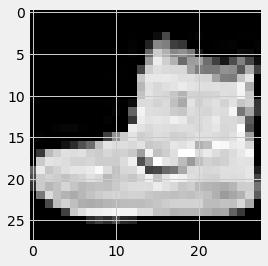

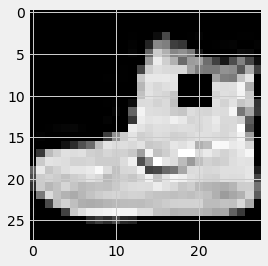

tensor(3417.)

In [485]:
train = FashionMNIST('.', download=True, train=True)
aff = tt.Compose([
    Lambda(lambda x: x.view(1, 28, 28)),
    tt.ToPILImage(),
    tt.RandomAffine(0, translate=(1 / 10, 1/10), shear=10, fillcolor=0),
    tt.ToTensor(),
    Lambda(lambda x: x.view(28, 28)),
])
x = train.train_data[0]
plt.imshow(x)
plt.show()
re = tt.Compose([
    Lambda(lambda z: z.view(1, 28, 28)),
    RandomErasing(1, sl=0.01, sh=0.05),
    Lambda(lambda z: z.view(28, 28)),
])
y = re(x.clone())
plt.imshow(y)
plt.show()
(y.type(torch.FloatTensor) - x.type(torch.FloatTensor)).abs().sum() 

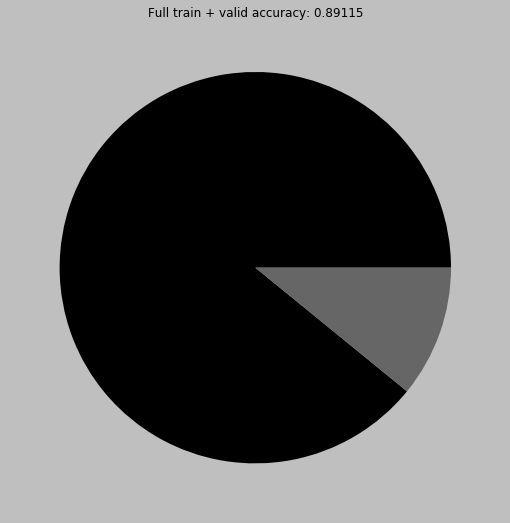

In [478]:
with switch_to_cpu(model):
    preds = model(next(iter(get_dl(train.train_data, train.train_labels, preprocess, 10000000)))[0]).argmax(dim=1)
    acc = accuracy_score(train.train_labels, preds)
plt.figure(figsize=(16, 9))
plt.pie([acc, 1 - acc])
plt.title("Full train + valid accuracy: %s" % acc) 
plt.show()

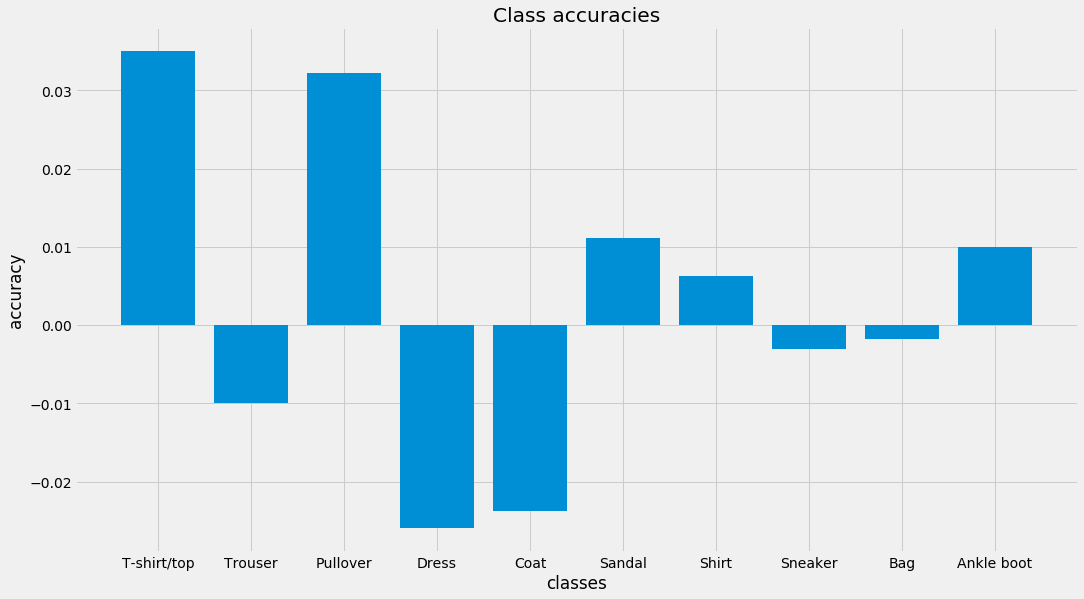

In [486]:
categorized = np.array([[x for x, y in zip(images, labels) if y == i] for i in range(10)])
str_labels = [
 'T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot'
]

with switch_to_cpu(model):
    acc = []
    for y, xs in enumerate(categorized):
        n = len(xs)
        ys = y * torch.ones(n)
        xs = next(iter(get_dl(torch.from_numpy(xs), ys, preprocess, n)))[0]
        acc.append(accuracy_score(ys, model(xs).argmax(dim=1)))

plt.figure(figsize=(16, 9))
plt.bar(str_labels, acc - baseline)
plt.xlabel('classes')
plt.ylabel('accuracy')
plt.title('Class accuracies')
plt.show()

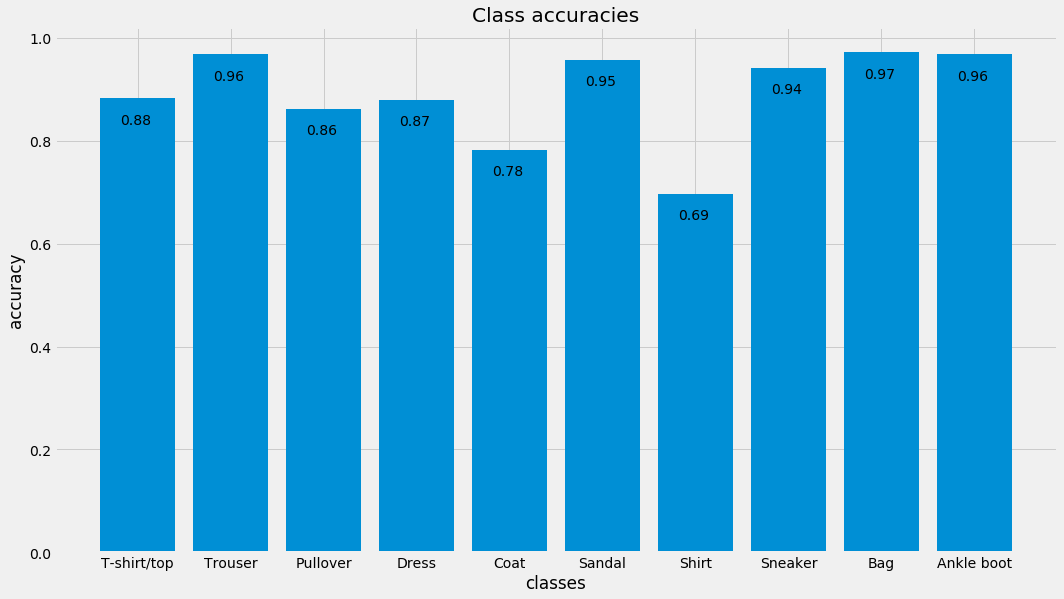

In [484]:
acc = []
with switch_to_cpu(model):
    for y, xs in enumerate(categorized):
        n = len(xs)
        ys = y * torch.ones(n)
        xs = next(iter(get_dl(torch.from_numpy(xs), ys, preprocess, n)))[0]
        acc.append(accuracy_score(ys, model(xs).argmax(dim=1)))

plt.figure(figsize=(16, 9))
plt.bar(str_labels, acc)
for i, v in enumerate(acc):
    plt.text(i - 0.19,  v - 0.05,  v * 100 // 1 / 100)
plt.xlabel('classes')
plt.ylabel('accuracy')
plt.title('Class accuracies')
plt.show()

In [487]:
test = FashionMNIST('.', download=True, train=False)
test_dl = get_dl(test.test_data, torch.ones(test.test_data.size(0)), preprocess, 10000)
with switch_to_cpu(model):
    preds = model(next(iter(test_dl))[0])
preds = preds.argmax(dim=1)
import pandas as pd
df = pd.DataFrame()
df['Class'] = preds
df.index.name = 'Id'
df.to_csv('submission.csv')
df

,Class
Id,
0,9
1,2
2,1
3,1
4,6
5,1
6,4
7,6
8,5
